In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib  # For saving the scalers
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score
import matplotlib.pyplot as plt

In [3]:
# Load datasets
train_df = pd.read_csv('train_data/train_data.csv')
test_df = pd.read_csv('train_data/test_data.csv')

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")
print(f"Unique Sessions in Train: {train_df['session_id'].nunique()}")

Train rows: 55870 | Test rows: 13777
Unique Sessions in Train: 96


In [4]:
train_df.describe()

,size,delay,bif,iat_mean,iat_std,throughput_mbps,delay_gradient,bif_gradient,is_silent,session_id,target_next_throughput
count,5.587000e+04,55870.000000,5.587000e+04,55870.000000,55870.000000,55870.000000,55870.000000,5.587000e+04,55870.000000,55870.000000,55870.000000
mean,3.179351e+06,52.058121,6.389954e+06,0.607896,0.282196,508.696082,0.004717,1.682308e+04,0.055056,47.290907,509.280471
std,2.253920e+06,21.182729,1.602745e+07,3.958253,1.552075,360.627168,10.773251,8.170338e+05,0.228092,27.686018,360.276606
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-175.013391,-7.924880e+06,0.000000,0.000000,0.000000
25%,1.176598e+06,47.418457,1.109898e+06,0.005842,0.004692,188.255600,-0.428177,-1.945180e+05,0.000000,23.000000,189.815360
50%,3.388660e+06,48.420232,3.641296e+06,0.008232,0.006902,542.185600,0.000000,0.000000e+00,0.000000,47.000000,542.527680
75%,4.787428e+06,51.506467,5.366960e+06,0.014073,0.013807,765.988480,0.634554,2.526520e+05,0.000000,71.000000,766.268480
max,1.790252e+07,207.815817,1.771334e+08,50.994000,35.743541,2864.403200,154.770312,9.954280e+06,1.000000,95.000000,2864.403200


In [6]:
test_df.describe()

,size,delay,bif,iat_mean,iat_std,throughput_mbps,delay_gradient,bif_gradient,is_silent,session_id,target_next_throughput
count,1.377700e+04,13777.000000,1.377700e+04,13777.000000,13777.000000,13777.000000,13777.000000,1.377700e+04,13777.000000,13777.000000,13777.000000
mean,3.419407e+06,58.116430,1.183624e+07,0.879799,0.263984,547.105066,0.015979,3.709406e+04,0.026784,11.604703,547.789433
std,2.823938e+06,25.792269,2.368032e+07,3.607198,1.082365,451.830154,12.296775,9.705781e+05,0.161457,7.007552,451.547897
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-120.387525,-2.342860e+07,0.000000,0.000000,0.000000
25%,6.409400e+05,47.466960,5.656000e+05,0.005869,0.004745,102.550400,-0.501622,-2.113880e+05,0.000000,5.000000,103.617920
50%,3.336100e+06,49.073745,4.044200e+06,0.008915,0.007696,533.776000,0.015409,4.000000e+00,0.000000,12.000000,534.476800
75%,5.374260e+06,54.834842,8.072340e+06,0.024958,0.043134,859.881600,0.946312,3.270400e+05,0.000000,18.000000,860.070400
max,1.823978e+07,209.213177,1.649333e+08,51.010000,34.031635,2918.364800,156.049338,3.005036e+07,1.000000,23.000000,2918.364800


In [5]:
# Define features and target
# We exclude 'ts' and 'session_id' from features
features = ['size', 'delay', 'bif', 'iat_mean', 'iat_std', 
            'throughput_mbps', 'delay_gradient', 'bif_gradient', 'is_silent']
target = 'target_next_throughput'

### Scaling

In [6]:
scaler = RobustScaler()

# Fit on training features only
train_df[features] = scaler.fit_transform(train_df[features])

# Transform testing features using training parameters
test_df[features] = scaler.transform(test_df[features])

print("Scaling complete. Data is now centered around the median with reduced outlier impact.")

Scaling complete. Data is now centered around the median with reduced outlier impact.


In [7]:
# Save Scalers (CRITICAL for live Tshark use later)
#joblib.dump(scaler, 'model_files/scaler_x.pkl')

### Session-Aware Sequence Building

In [ ]:
def create_session_sequences(df, feature_cols, target_col, window_size):
    X, y = [], []
    
    # Process each session independently to avoid "data bleeding"
    for session_id, group in df.groupby('session_id'):
        data = group[feature_cols].values
        labels = group[target_col].values
        
        if len(data) < window_size:
            continue
            
        for i in range(len(data) - window_size):
            X.append(data[i : i + window_size])
            y.append(labels[i + window_size])
            
    return np.array(X), np.array(y)

WINDOW_SIZE = 15 # 15 windows * 50ms = 750ms look-back

X_train, y_train = create_session_sequences(train_df, features, target, WINDOW_SIZE)
X_test, y_test = create_session_sequences(test_df, features, target, WINDOW_SIZE)

# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### Defining the LSTM Architecture

In [9]:
class TrafficLSTM(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2):
        super(TrafficLSTM, self).__init__()
        # Increased hidden_dim to 128 to capture more complex patterns
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)
        c0 = torch.zeros(2, x.size(0), 128).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

In [10]:
model = TrafficLSTM()
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### Training Loop

In [12]:
train_loader = DataLoader(list(zip(X_train_t, y_train_t)), batch_size=64, shuffle=True)

epochs = 20
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 1/20, Loss: 118.295815
Epoch 2/20, Loss: 79.819077
Epoch 3/20, Loss: 67.277519
Epoch 4/20, Loss: 62.291130
Epoch 5/20, Loss: 60.037205
Epoch 6/20, Loss: 31.886108
Epoch 7/20, Loss: 41.598019
Epoch 8/20, Loss: 34.692089
Epoch 9/20, Loss: 60.596233
Epoch 10/20, Loss: 58.542801
Epoch 11/20, Loss: 37.974487
Epoch 12/20, Loss: 70.022797
Epoch 13/20, Loss: 49.287010
Epoch 14/20, Loss: 29.968426
Epoch 15/20, Loss: 43.631294
Epoch 16/20, Loss: 47.977108
Epoch 17/20, Loss: 18.517237
Epoch 18/20, Loss: 39.198650
Epoch 19/20, Loss: 58.726517
Epoch 20/20, Loss: 48.891762


In [ ]:
# Save the weights
torch.save(model.state_dict(), 'model_files/other_tcp_forecast_model.pth')

# Save Entire Model
torch.save(model, 'model_files/other_model_architecture.pt')

In [ ]:
# Load the .pth file
model_path = "model_files/tcp_forecast_model.pth"
state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

### Model Evaluation

In [12]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_t)
    test_loss = criterion(predictions, y_test_t)

    y_pred_rescaled = predictions.numpy().flatten()
    y_test_rescaled = y_test_t.numpy().flatten()
    
# Convert back to original scale (optional, but useful for Mbps visualization)
# Since we predicted throughput_mbps, we can compare directly
print(f"Test Huber Loss: {test_loss.item():.4f}")

# Sample Comparison
for i in range(10):
    print(f"Actual: {y_test[i]:.2f} Mbps | Predicted: {predictions[i].item():.2f} Mbps")

Test Huber Loss: 68.7053
Actual: 421.87 Mbps | Predicted: 287.60 Mbps
Actual: 555.60 Mbps | Predicted: 526.02 Mbps
Actual: 746.02 Mbps | Predicted: 658.76 Mbps
Actual: 734.00 Mbps | Predicted: 698.20 Mbps
Actual: 785.08 Mbps | Predicted: 750.19 Mbps
Actual: 668.12 Mbps | Predicted: 797.82 Mbps
Actual: 574.72 Mbps | Predicted: 793.72 Mbps
Actual: 667.94 Mbps | Predicted: 769.48 Mbps
Actual: 184.25 Mbps | Predicted: 479.13 Mbps
Actual: 184.40 Mbps | Predicted: 197.92 Mbps


In [13]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.2f} Mbps")
print(f"R2 Score: {r2:.2f}")

MAE: 69.17 Mbps
R2 Score: 0.92


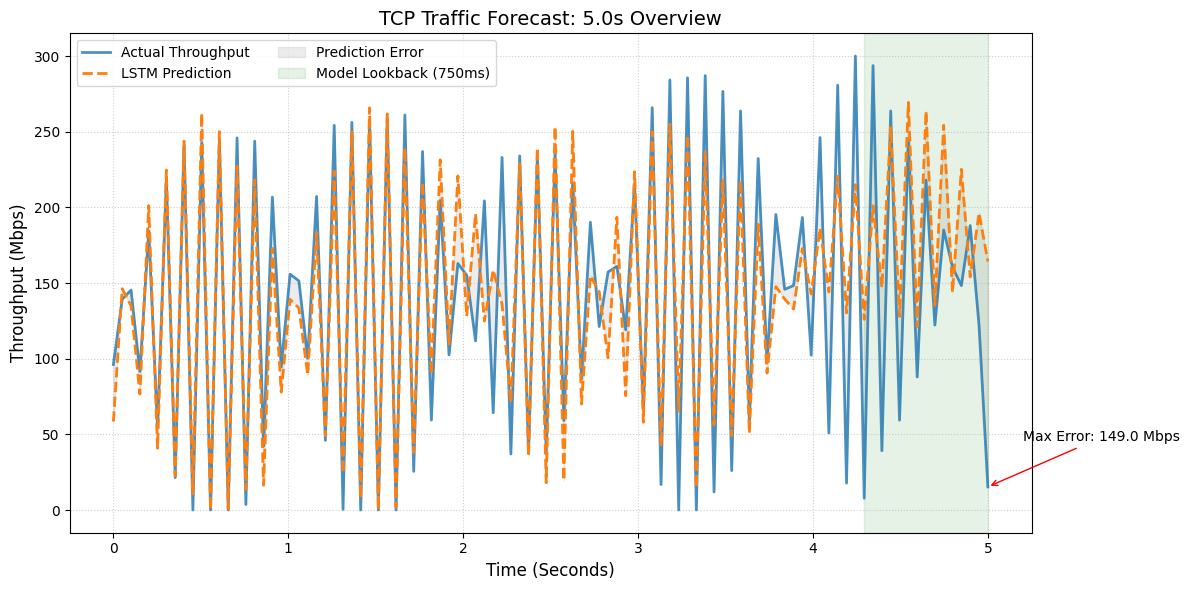

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
MS_PER_POINT = 50 
LOOKBACK_MS = 750
DISPLAY_MS = 5000  # Show 5 seconds instead of just 0.75s

# Calculate points
lookback_points = LOOKBACK_MS // MS_PER_POINT  # 15 points
display_points = DISPLAY_MS // MS_PER_POINT    # 100 points

# Slice the data for the display window
actual = y_test_rescaled[-display_points:]
predicted = y_pred_rescaled[-display_points:]

# Time axis in seconds (0 to 5.0s)
time_axis = np.linspace(0, DISPLAY_MS / 1000, display_points)

plt.figure(figsize=(12, 6), dpi=100)

# 1. Plotting the full display range
plt.plot(time_axis, actual, label='Actual Throughput', 
         color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(time_axis, predicted, label='LSTM Prediction', 
         color='#ff7f0e', linestyle='--', linewidth=2)

# 2. Shaded Error Area for the whole range
plt.fill_between(time_axis, actual, predicted, color='gray', alpha=0.15, label='Prediction Error')

# 3. NEW: Highlight the "Memory" Window
# This shows the 750ms context the model uses for the final prediction point
plt.axvspan(time_axis[-lookback_points], time_axis[-1], 
            color='green', alpha=0.1, label='Model Lookback (750ms)')

# Labels and Title
plt.title(f"TCP Traffic Forecast: {DISPLAY_MS/1000}s Overview", fontsize=14)
plt.xlabel("Time (Seconds)", fontsize=12)
plt.ylabel("Throughput (Mbps)", fontsize=12)

# 4. Dynamic Annotation for the entire view
error = np.abs(actual - predicted)
max_err_idx = np.argmax(error)
plt.annotate(f'Max Error: {error[max_err_idx]:.1f} Mbps', 
             xy=(time_axis[max_err_idx], actual[max_err_idx]), 
             xytext=(time_axis[max_err_idx] + 0.2, actual[max_err_idx] + 30),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left', frameon=True, ncol=2)
plt.tight_layout()
plt.show()

In [17]:
# AUC for 'Congestion Event' Detection
# We define a crash as throughput dropping below 20 Mbps
threshold = 20
actual_crash = (y_test_rescaled < threshold).astype(int)
predicted_crash = (y_pred_rescaled < threshold).astype(int)
auc = roc_auc_score(actual_crash, predicted_crash)

In [18]:
print(f"Average Prediction Error: {mae:.2f} Mbps")
print(f"R-Squared (Variance Explained): {r2:.4f}")
print(f"Congestion Warning AUC: {auc:.4f}")

Average Prediction Error: 69.17 Mbps
R-Squared (Variance Explained): 0.9192
Congestion Warning AUC: 0.9596
